<a href="https://colab.research.google.com/github/francesco-schinea/NAMLproject_OscarPredictions/blob/main/OscarPredictions_bestpicture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
class SVC:
    """
    Implementazione di un Support Vector Classifier lineare con Hinge Loss
    utilizzando JAX.
    """

    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_epochs=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_epochs = n_epochs
        self.w = None
        self.b = None

        # Compiliamo la funzione di gradiente usando JAX
        self._grad_loss = jax.jit(jax.grad(self._hinge_loss, argnums=(0, 1)))

    def _hinge_loss(self, w, b, X, y):
        """
        Calcola la Hinge Loss.
        y deve essere in formato {-1, 1}.
        """
        # Calcola il margine: y * (w*x - b)
        margin = y * (jnp.dot(X, w) - b)

        # Calcola la loss per campione: max(0, 1 - margin)
        loss_per_sample = jnp.maximum(0, 1 - margin)

        # Loss media
        mean_loss = jnp.mean(loss_per_sample)

        # Aggiungi regolarizzazione L2
        regularization = (self.lambda_param / 2) * jnp.dot(w, w)

        total_loss = mean_loss + regularization
        return total_loss

    def fit(self, X, y):
        """
        Addestra il modello SVC.
        X: (n_samples, n_features)
        y: (n_samples,) con valori {-1, 1}
        """
        n_samples, n_features = X.shape

        # Inizializza i parametri
        key = jax.random.PRNGKey(0)
        self.w = jax.random.normal(key, shape=(n_features,)) * 0.01
        self.b = 0.0

        # Ciclo di addestramento
        for epoch in range(self.n_epochs):
            # Calcola i gradienti
            dw, db = self._grad_loss(self.w, self.b, X, y)

            # Aggiorna i parametri (discesa del gradiente)
            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db

            # (Opzionale) Stampa la loss ogni N epoche
            # if epoch % 200 == 0:
            #     loss = self._hinge_loss(self.w, self.b, X, y)
            #     print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        """
        Effettua previsioni { -1, 1 }
        """
        # Calcola l'output lineare
        linear_output = jnp.dot(X, self.w) - self.b

        # Restituisce il segno: 1 se > 0, -1 se <= 0
        # Usiamo 0.0 come soglia.
        return jnp.where(linear_output > 0, 1, -1)

In [12]:
print("Caricamento dati...")
file_path = "oscardata_bestpicture.csv"

try:
    df = pd.read_csv(file_path)
    print(f"Dati caricati con successo: {df.shape[0]} righe e {df.shape[1]} colonne.")
except FileNotFoundError:
    print(f"--- ERRORE ---")
    print(f"File non trovato al percorso: '{file_path}'")
    print("Assicurati che 'oscardata_bestpicture.csv' sia nella stessa cartella del notebook.")
    # Alziamo un'eccezione per fermare l'esecuzione
    raise

Caricamento dati...
Dati caricati con successo: 390 righe e 60 colonne.


In [28]:
# Definiamo le colonne da usare
cols_to_drop = [
    'Category', 'Film', 'Nominee', 'Release_date', 'MPAA_rating',
    'Winner',
    'Year'
]
feature_cols = [col for col in df.columns if col not in cols_to_drop]
target_col = 'Winner'

print(f"Usate {len(feature_cols)} feature.")

# --- Nuova Logica di Split (70/30 totalmente casuale) ---

# 1. Estrai TUTTI i dati (feature, target e info)
X_full_raw = df[feature_cols].values
y_full_raw = df[target_col].values
info_full = df[['Year', 'Film']]

print(f"Totale campioni da dividere: {len(X_full_raw)}")

# 2. Esegui lo split 70/30 su TUTTI i dati
# test_size=0.30 significa 30% test e il resto (70%) training
X_train_raw, X_test_raw, y_train_raw, y_test_raw, info_train, info_test = train_test_split(
    X_full_raw,
    y_full_raw,
    info_full,
    test_size=0.30,  # 30% nel test set
    random_state=42, # Per riproducibilità
    shuffle=True     # Mescola i dati (molto importante)
)

print("\n--- Dimensioni finali ---")
print(f"X_train: {X_train_raw.shape}")
print(f"y_train: {y_train_raw.shape}")
print(f"X_test:  {X_test_raw.shape}")
print(f"y_test:  {y_test_raw.shape}")

total_check = len(X_train_raw) + len(X_test_raw)
print(f"Totale campioni: {total_check} (Originale: {len(df)})")
print(f"Percentuale Test: {len(X_test_raw) / total_check * 100:.2f}%")

Usate 53 feature.
Totale campioni da dividere: 390

--- Dimensioni finali ---
X_train: (273, 53)
y_train: (273,)
X_test:  (117, 53)
y_test:  (117,)
Totale campioni: 390 (Originale: 390)
Percentuale Test: 30.00%


In [18]:
# Definiamo le colonne da usare
cols_to_drop = [
    'Category', 'Film', 'Nominee', 'Release_date', 'MPAA_rating',
    'Winner',
    'Year'
]
feature_cols = [col for col in df.columns if col not in cols_to_drop]
target_col = 'Winner'

print(f"Usate {len(feature_cols)} feature.")

# --- Nuova Logica di Split ---

# 1. Identifica i campioni che DEVONO essere nel test set
test_years = [2021, 2022, 2023, 2024, 2025]
df_must_test = df[df['Year'].isin(test_years)]
df_other = df[~df['Year'].isin(test_years)]

print(f"Campioni 'obbligatori' nel test set (anni {test_years}): {len(df_must_test)}")

# 2. Estrai X e y per entrambi i gruppi
X_must_test_raw = df_must_test[feature_cols].values
y_must_test_raw = df_must_test[target_col].values
# (Salviamo anche le info per l'analisi finale)
info_must_test = df_must_test[['Year', 'Film']]

X_other_raw = df_other[feature_cols].values
y_other_raw = df_other[target_col].values
info_other = df_other[['Year', 'Film']]

# 3. Calcola le dimensioni per lo split 70/30
total_samples = len(df)
target_test_size = int(total_samples * 0.30)
target_train_size = total_samples - target_test_size

# 4. Calcola quanti campioni CI MANCANO per il training
# (Dobbiamo riempire il training set dall'70% di 'df_other')
# target_train_size è l'80% del totale. Tutti i nostri dati di train DEVONO venire
# da df_other.
train_size_from_other = target_train_size
# La dimensione del test aggiuntivo sarà il resto di df_other
test_size_from_other = len(df_other) - train_size_from_other

print(f"Split desiderato: {target_train_size} (70%) train / {target_test_size} (30%) test")

# 5. Esegui lo split su 'df_other' per ottenere il training set e il test set aggiuntivo
# Usiamo 'train_size' per definire l'80% del totale
X_train_raw, X_additional_test_raw, y_train_raw, y_additional_test_raw, info_train, info_additional_test = train_test_split(
    X_other_raw,
    y_other_raw,
    info_other,
    train_size=train_size_from_other,
    random_state=42, # Per riproducibilità
    shuffle=True
)

# 6. Unisci i dati di test
X_test_raw = np.concatenate((X_must_test_raw, X_additional_test_raw))
y_test_raw = np.concatenate((y_must_test_raw, y_additional_test_raw))
info_test = pd.concat((info_must_test, info_additional_test))

print("\n--- Dimensioni finali ---")
print(f"X_train: {X_train_raw.shape}")
print(f"y_train: {y_train_raw.shape}")
print(f"X_test:  {X_test_raw.shape}")
print(f"y_test:  {y_test_raw.shape}")

total_check = len(X_train_raw) + len(X_test_raw)
print(f"Totale campioni: {total_check} (Originale: {total_samples})")
print(f"Percentuale Test: {len(X_test_raw) / total_check * 100:.2f}%")

Usate 53 feature.
Campioni 'obbligatori' nel test set (anni [2021, 2022, 2023, 2024, 2025]): 48
Split desiderato: 273 (80%) train / 117 (20%) test

--- Dimensioni finali ---
X_train: (273, 53)
y_train: (273,)
X_test:  (117, 53)
y_test:  (117,)
Totale campioni: 390 (Originale: 390)
Percentuale Test: 30.00%


In [29]:
# --- Normalizzazione (Scaling) ---
# Addestriamo lo scaler SOLO sui dati di training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)

# Applichiamo la stessa trasformazione ai dati di test
X_test_scaled = scaler.transform(X_test_raw)

# --- Trasformazione Target per Hinge Loss ---
# Trasformiamo y_train da {0, 1} a {-1, 1}
print(f"Esempio y_train originale: {y_train_raw[:15]}")
y_train_transformed = jnp.where(y_train_raw == 0, -1, 1)
print(f"Esempio y_train trasformato: {y_train_transformed[:15]}")


# --- Conversione finale in JAX ---
X_train = jnp.array(X_train_scaled)
y_train = jnp.array(y_train_transformed) # Questo ora è {-1, 1}
X_test = jnp.array(X_test_scaled)
# y_test_raw (che è {0, 1}) è già un array numpy, pronto per la valutazione

print("\nDati pronti per l'addestramento.")

Esempio y_train originale: [0 0 1 1 1 0 0 1 0 0 0 0 0 0 0]
Esempio y_train trasformato: [-1 -1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1]

Dati pronti per l'addestramento.


In [30]:
# Definiamo gli iperparametri
LEARNING_RATE = 0.001
LAMBDA_PARAM = 0.01
EPOCHS = 2000

# Inizializza e addestra il modello
svc_model = SVC(learning_rate=LEARNING_RATE, lambda_param=LAMBDA_PARAM, n_epochs=EPOCHS)

print("Inizio addestramento...")
svc_model.fit(X_train, y_train)
print("Addestramento completato.")

Inizio addestramento...
Addestramento completato.


In [31]:
# Ottieni previsioni (saranno -1 o 1)
y_pred_transformed = svc_model.predict(X_test)

# Converti le previsioni {-1, 1} di nuovo in {0, 1} per confrontarle
y_pred_original_format = jnp.where(y_pred_transformed == -1, 0, 1)

# Ora confrontiamo y_pred_original_format (0/1) con y_test_raw (0/1)

# Creiamo "maschere" booleane
actual_winners_mask = (y_test_raw == 1)
predicted_winners_mask = (y_pred_original_format == 1)

# Calcola l'intersezione (dove entrambi sono 1)
correctly_predicted_winners = jnp.sum(actual_winners_mask & predicted_winners_mask)

# Calcola il totale dei vincitori reali
total_actual_winners = jnp.sum(actual_winners_mask)

# Calcola l'accuratezza personalizzata
if total_actual_winners > 0:
    winner_accuracy = correctly_predicted_winners / total_actual_winners
else:
    winner_accuracy = 0.0 # Evita divisione per zero

# --- Risultati ---
print("\n--- Risultati della Valutazione ---")
print(f"Vincitori totali reali nel Test Set: {total_actual_winners}")
print(f"Film predetti come vincitori dal modello: {jnp.sum(predicted_winners_mask)}")
print(f"Vincitori predetti CORRETTAMENTE: {correctly_predicted_winners}")
print("\n-------------------------------------")
print(f"Accuratezza sui *soli* vincitori: {winner_accuracy * 100:.2f}%")
print("-------------------------------------")

# Mostra un confronto dettagliato (opzionale)
results_df = pd.DataFrame({
    'Anno': info_test['Year'],
    'Film': info_test['Film'],
    'Reale': y_test_raw,
    'Predetto': y_pred_original_format
})

# Stampa solo i vincitori reali e le relative previsioni
print("\nDettaglio previsioni sui vincitori reali:")
print(results_df[results_df['Reale'] == 1].sort_values(by='Anno', ascending=False))

# Stampa solo i film che il modello ha predetto come vincitori
print("\nDettaglio film predetti come vincitori:")
print(results_df[results_df['Predetto'] == 1].sort_values(by='Anno', ascending=False))


--- Risultati della Valutazione ---
Vincitori totali reali nel Test Set: 23
Film predetti come vincitori dal modello: 26
Vincitori predetti CORRETTAMENTE: 19

-------------------------------------
Accuratezza sui *soli* vincitori: 82.61%
-------------------------------------

Dettaglio previsioni sui vincitori reali:
     Anno                                             Film  Reale  Predetto
376  2024                                      Oppenheimer      1         1
351  2022                                             CODA      1         0
326  2019                                       Green Book      1         0
291  2015  Birdman or (The Unexpected Virtue of Ignorance)      1         1
265  2012                                       The Artist      1         1
255  2011                                The King's Speech      1         1
245  2010                                  The Hurt Locker      1         1
225  2006                                            Crash      1       

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    PrecisionRecallDisplay,
    RocCurveDisplay
)

--- Classification Report ---
                   precision    recall  f1-score   support

Non-Vincitore (0)       0.97      0.92      0.94       102
    Vincitore (1)       0.60      0.80      0.69        15

         accuracy                           0.91       117
        macro avg       0.78      0.86      0.82       117
     weighted avg       0.92      0.91      0.91       117


--- Matrice di Confusione ---
Matrice di confusione salvata come 'confusion_matrix.png'


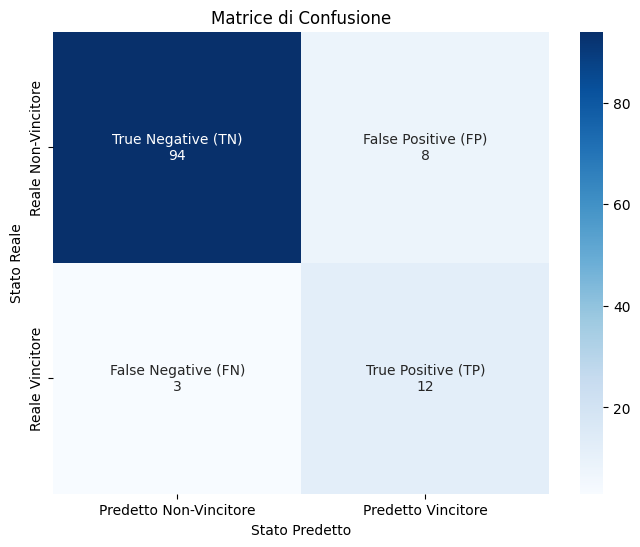

In [24]:
# --- 1. Classification Report ---
# Stampa Precision, Recall e F1-Score
# Questo è FONDAMENTALE per dati sbilanciati

print("--- Classification Report ---")
# Usiamo le variabili y_test_raw (reali 0/1) e y_pred_original_format (predetti 0/1)
print(classification_report(y_test_raw, y_pred_original_format,
                            target_names=['Non-Vincitore (0)', 'Vincitore (1)']))

# --- 2. Matrice di Confusione ---
print("\n--- Matrice di Confusione ---")
cm = confusion_matrix(y_test_raw, y_pred_original_format)

# Definiamo le etichette per la matrice
labels = ['Predetto Non-Vincitore', 'Predetto Vincitore']
categories = ['Reale Non-Vincitore', 'Reale Vincitore']
group_counts = [f"{value}" for value in cm.flatten()]
group_names = ['True Negative (TN)', 'False Positive (FP)',
               'False Negative (FN)', 'True Positive (TP)']
box_labels = [f"{name}\n{count}" for name, count in zip(group_names, group_counts)]
box_labels = np.asarray(box_labels).reshape(2,2)

# Grafico con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=box_labels, fmt='', cmap='Blues',
            xticklabels=labels, yticklabels=categories)
plt.title('Matrice di Confusione')
plt.ylabel('Stato Reale')
plt.xlabel('Stato Predetto')
plt.savefig("confusion_matrix.png") # Salva l'immagine
print("Matrice di confusione salvata come 'confusion_matrix.png'")
# plt.show() # Se sei in un notebook, puoi usare plt.show() al posto di savefig

In [25]:
# Le curve ROC e P-R non usano la predizione (1 o 0)
# ma il punteggio grezzo (il "decision score").
# Lo ricalcoliamo usando i pesi (w) e il bias (b) del modello addestrato.

# X_test, svc_model.w e svc_model.b dovrebbero essere disponibili dalle celle precedenti
y_scores = jnp.dot(X_test, svc_model.w) - svc_model.b

# Converti in array NumPy per usarlo con scikit-learn
y_scores_np = np.array(y_scores)

print("Punteggi di decisione calcolati per il test set.")

Punteggi di decisione calcolati per il test set.


Curva Precision-Recall salvata come 'precision_recall_curve.png'


<Figure size 640x480 with 0 Axes>

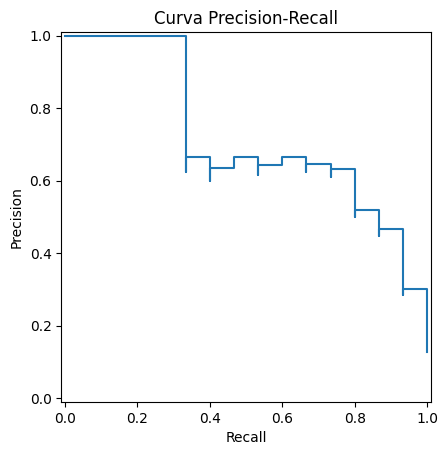

In [26]:
# Calcoliamo i valori per la curva P-R
precision, recall, _ = precision_recall_curve(y_test_raw, y_scores_np, pos_label=1)

# Crea e salva il grafico
plt.figure()
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()
plt.title('Curva Precision-Recall')
plt.savefig('precision_recall_curve.png')
print("Curva Precision-Recall salvata come 'precision_recall_curve.png'")


Punteggio AUC: 0.9366
Curva ROC salvata come 'roc_curve.png'


<Figure size 640x480 with 0 Axes>

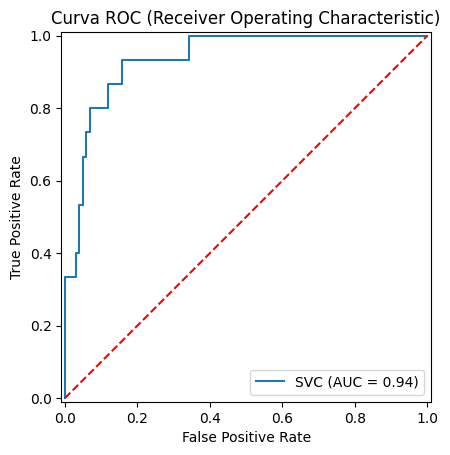

In [27]:
# Calcoliamo i valori per la curva ROC
fpr, tpr, _ = roc_curve(y_test_raw, y_scores_np, pos_label=1)

# Calcoliamo l'Area Sotto la Curva (AUC)
auc_score = roc_auc_score(y_test_raw, y_scores_np)
print(f"\nPunteggio AUC: {auc_score:.4f}")

# Crea e salva il grafico
plt.figure()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score, estimator_name='SVC')
roc_display.plot()
plt.plot([0, 1], [0, 1], 'r--') # Linea di riferimento (caso)
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.savefig('roc_curve.png')
print("Curva ROC salvata come 'roc_curve.png'")